In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 5.6 Homography
* Homography를 이용해 scanner app 만들기 가능

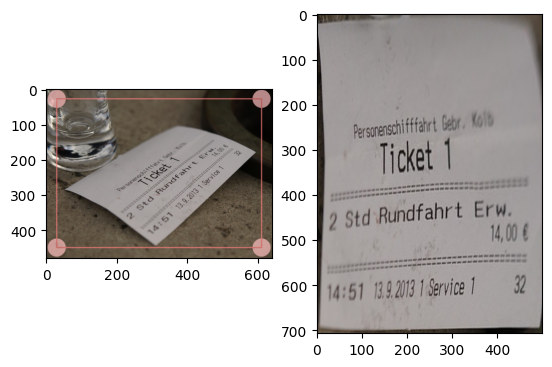

In [2]:
# 관심영역을 모서리 네개로 선택하는 함수
def drawROI(img, corners): # corners는 아래의 scrQuad 좌표
    corners = np.int32(corners)
    cpy = img.copy() # 전송받은 이미지의 복사본을 만들어서 그 위에 그림을 그립니다.
    
    c1 = (192, 192, 255) # 모서리 색상 BGR
    c2 = (128, 128, 255) # 선 색상 BGR
    
    for pt in corners: # 모서리 수 만큼 원 생성, corners 정보 이용
        cv2.circle(cpy, np.int32(pt), 25, c1, -1, cv2.LINE_AA)
        
    # 모서리를 잇는 선, 점들의 좌표는 튜플
    cv2.line(cpy, tuple(corners[0]), tuple(corners[1]), c2, 2, cv2.LINE_AA)
    cv2.line(cpy, tuple(corners[1]), tuple(corners[2]), c2, 2, cv2.LINE_AA)
    cv2.line(cpy, tuple(corners[2]), tuple(corners[3]), c2, 2, cv2.LINE_AA)
    cv2.line(cpy, tuple(corners[3]), tuple(corners[0]), c2, 2, cv2.LINE_AA)
    
    # addWeighted를 이용해서 입력 영상과 cpy영상에 가중치를 적용하여 투명도 적용
    # 모서리와 선 밑에 잇는 글씨도 보임. 하지만 연산이 오래 걸린다
    disp = cv2.addWeighted(img, 0.3, cpy, 0.7, 0)
    
    return disp
    
# 마우스 이벤트 처리
def onMouse(event, x, y, flags, param): # 외관상 5개 인자. flags는 키가 눌린 여부, param은 전송 데이터
    global srcQuad, dragSrc, pt0ld, src # 전역 변수 갖고 옴
    
    # 왼쪽 마우스가 눌렸을 때
    if event == cv2.EVENT_LBUTTONDOWN:
        for i in range(4):
            if cv2.norm(srcQuad[i] - (x, y)) < 25: # 클릭한 점이 원 안에 있는지 확인
                dragSrc[i] = True
                pt0ld = (x, y) # 마우스를 이동할때 모서리도 따라 움직이도록 설정
                break
    
    if event == cv2.EVENT_LBUTTONUP: # 마우스를 땜
        for i in range(4):
            dragSrc[i] = False
    
    if event == cv2.EVENT_MOUSEMOVE: # 마우스 왼쪽 버튼이 눌려 있을 때 모서리 움직임
        for i in range(4):
            if dragSrc[i]: # dragSrc가 True일 때
                dx = x - pt0ld[0] # 이전의 마우스 점에서 dx, dy만큼 이동
                dy = y - pt0ld[1]
                
                srcQuad[i] += (dx, dy) # 이동한 만큼 더해줌
                
                cpy = drawROI(src, srcQuad)
                cv2.imshow('img', cpy) # 수정된 좌표로 모서리 이동
                pt0ld = (x, y) # 현재 점으로 설정
                
                
# 입력 이미지 불러오기
src = cv2.imread('./imgs/receipt.jpg')
    
# 입력 영상 크기 및 출력 영상 크기
h, w = src.shape[:2]
dw = 500 # 똑바로 핀 영상의 가로 크기
dh = round(dw * 297 / 210) # A4 용지 크기: 210x297cm 이용

# 모서리 점들의 좌표, 드래그 상태 여부
# 내가 선택하려는 모서리 점 4개를 저장하는 넘파이 행렬, 30은 임의로 초기점의 좌표를 설정
# 완전히 구석이 아니라 모서리를 클릭할 수 있도록 자리를 둠
srcQuad = np.array([[30, 30], [30, h-30], [w-30, h-30], [w-30, 30]], np.float32) # 모서리 위치
# 반시계 방향으로 출력 방향의 위치
dstQuad = np.array([[0, 0], [0, dh-1], [dw-1, dh-1], [dw-1, 0]], np.float32)

# 4개의 점 중에서 현재 어떤 점을 드래고 하고 있나 상태를 저장, 점을 선택하면 True, 떼면 False
dragSrc = [False, False, False, False]

# 모서리점, 사각형 그리기
# src에 srcQuad좌표를 전송해서 화면에 나타냄
disp = drawROI(src, srcQuad)

cv2.imshow('img',disp)
cv2.setMouseCallback('img', onMouse)

while True:
    key = cv2.waitKey()
    if key == 13: # enter키, 엔터키 누르면 투시 변환과 결과 영상 출력
        break
    elif key == 27: # ESC 키 종료
        cv2.destroyWindow('img')
        
# 투시변환
# pers = cv2.getPerspectiveTransform(srcQuad, dstQuad) # 3X3 투시 변환 행렬 생성
pers, _ = cv2.findHomography(srcQuad, dstQuad)
dst = cv2.warpPerspective(src, pers, (dw, dh), flags=cv2.INTER_CUBIC) # 가로 세로 크기는 자동

# 결과 영상 출력
cv2.imshow('dst',dst)
cv2.waitKey()
cv2.destroyAllWindows()

plt.subplot(1, 2, 1)
plt.imshow(disp[..., ::-1])
plt.subplot(1, 2, 2)
plt.imshow(dst[..., ::-1])

# 연습문제

In [3]:
# 문제 1
image = np.zeros((10, 10))
for idx, i in enumerate(range(2, 7)):
    for c in range(idx + 1):
        image[i, c + 3] = 1

def cal_s(image, y, x):
    A = image[y-1:y+2, x-1:x+2]
    s_values = []
    for v in [-1, 0, 1]:
        for u in [-1, 0, 1]:
            B = image[y-1+v:y+2+v, x-1+u:x+2+u]
            s = np.sum((A-B)**2)
            s_values.append(s)
    return np.array(s_values).reshape(3, 3)

# (1)
s = cal_s(image, 6, 3)
c = np.min([s[1,2], s[1,0], s[2,0], s[0,1]])
print(s, c)
# (2)
s = cal_s(image, 4, 5)
c = np.min([s[1,2], s[1,0], s[2,0], s[0,1]])
print(s, c)

[[3. 2. 5.]
 [2. 0. 2.]
 [3. 2. 3.]] 2.0
[[0. 3. 5.]
 [2. 0. 3.]
 [3. 2. 0.]] 2.0


In [4]:
# 문제 2
image = np.zeros((10, 10), dtype=np.float32)
for idx, i in enumerate(range(2, 7)):
    for c in range(idx + 1):
        image[i, c + 3] = 1
        
ux = np.array([-1, 0, 1])
uy = ux.T
k = cv2.getGaussianKernel(3, 1)
g = np.outer(k, k.T)

dy = cv2.filter2D(image, cv2.CV_32F, uy)
dx = cv2.filter2D(image, cv2.CV_32F, ux)
dyy = dy*dy
dxx = dx*dx
dyx = dy*dx
gdyy = cv2.filter2D(dyy, cv2.CV_32F, g)
gdxx = cv2.filter2D(dxx, cv2.CV_32F, g)
gdyx = cv2.filter2D(dyx, cv2.CV_32F, g)
C = (gdyy*gdxx - gdyx*gdyx)-0.04*(gdyy+gdxx)*(gdyy+gdxx)

# (1)
A = np.array([[gdyy[6,3], gdyx[6,3]],
             [gdyx[6,3], gdxx[6,3]]])
print(A, C[6,3])
# (2)
A = np.array([[gdyy[4,5], gdyx[4,5]],
             [gdyx[4,5], gdxx[4,5]]])
print(A, C[4,5])

[[0.52697635 0.52697635]
 [0.52697635 0.52697635]] -0.04443265
[[0.60208994 0.60208994]
 [0.60208994 0.60208994]] -0.05800197


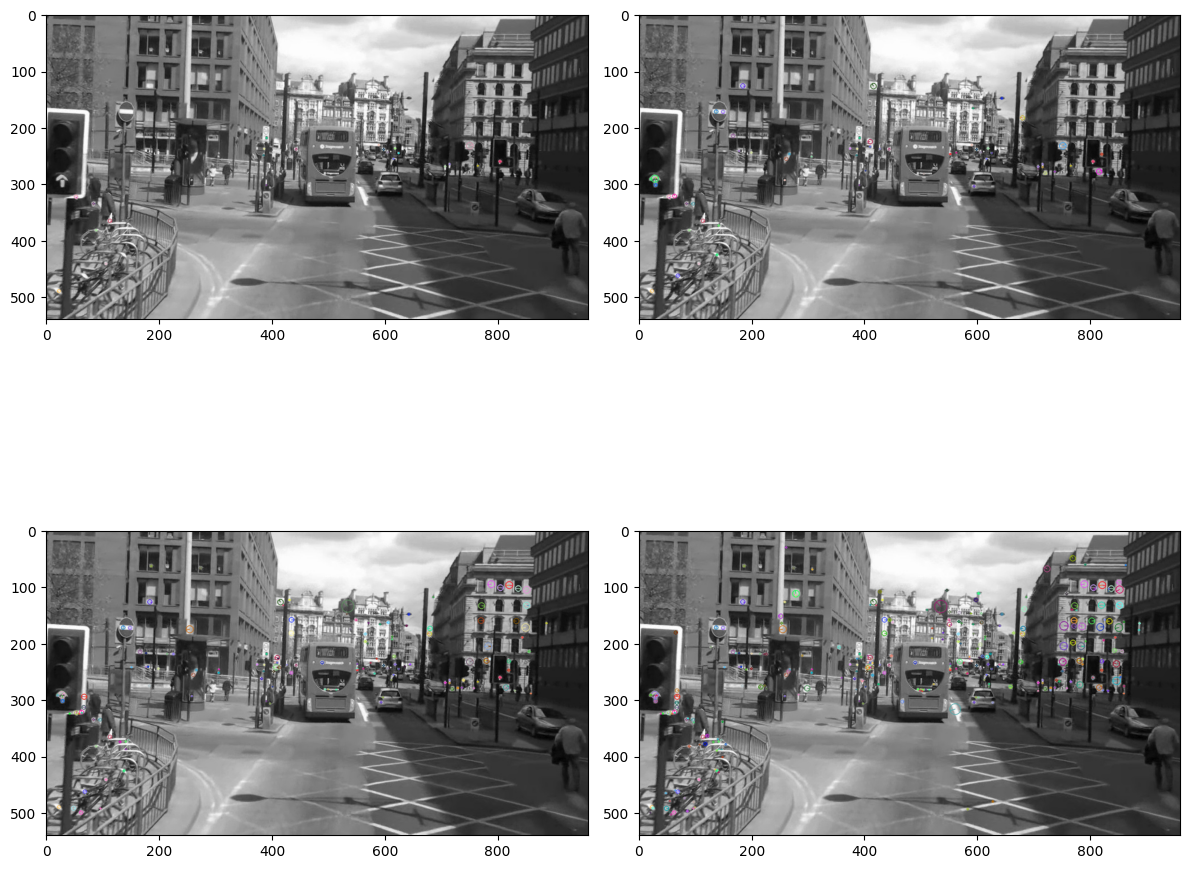

In [5]:
img=cv2.imread('./imgs/mot_color70.jpg') # 영상 읽기
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


plt.figure(figsize=(12, 12))
for i in range(5, 9):
    sift=cv2.SIFT_create(nfeatures=2**i) 
    kp,des=sift.detectAndCompute(gray,None)

    gray=cv2.drawKeypoints(gray,kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.subplot(2, 2, i - 4)
    plt.imshow(gray)
plt.tight_layout()

In [6]:
# 문제 4
'''
적분 이미지를 사용
descriptor 차원 수 축소
contrast를 이용한 빠른 매칭
'''

'\n적분 이미지를 사용\ndescriptor 차원 수 축소\ncontrast를 이용한 빠른 매칭\n'

In [7]:
# 문제 5
'''
eliminate the keypoints that have low contrast or lie very close to the edge
To deal with the low contrast keypoints, a second-order Taylor expansion is computed for each keypoint. 
If the resulting value is less than 0.03 (in magnitude), we reject the keypoint
'''

'\neliminate the keypoints that have low contrast or lie very close to the edge\nTo deal with the low contrast keypoints, a second-order Taylor expansion is computed for each keypoint. \nIf the resulting value is less than 0.03 (in magnitude), we reject the keypoint\n'

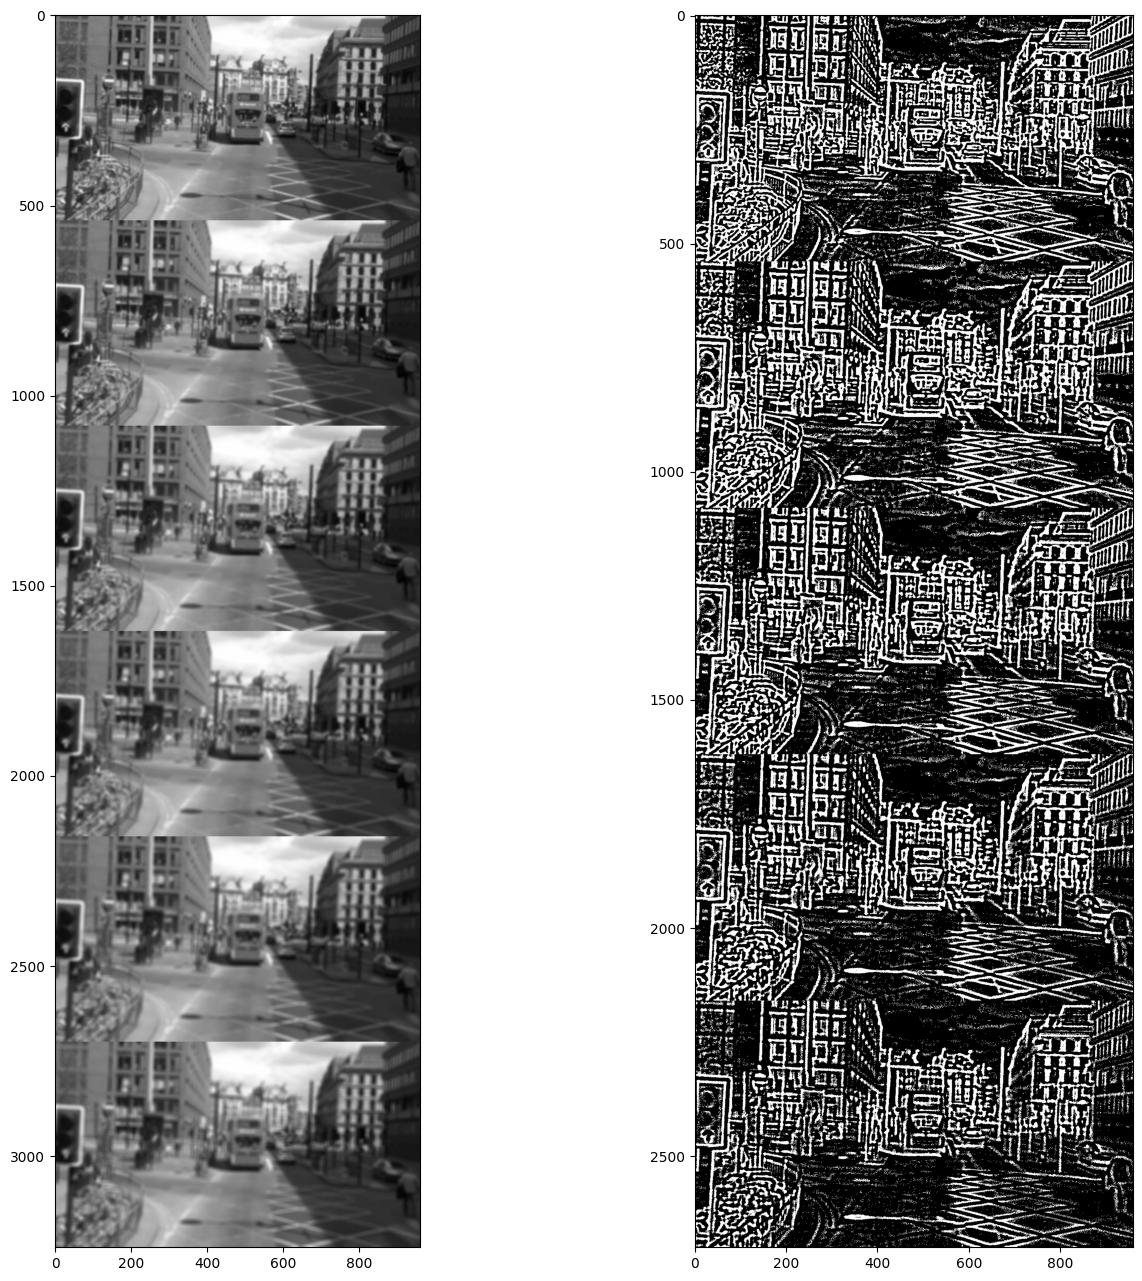

In [8]:
# 문제 6
image = cv2.imread('./imgs/mot_color70.jpg', cv2.IMREAD_GRAYSCALE)
sigma = 1.6
imgs = []
for i in range(1, 7):
    blur = cv2.GaussianBlur(image, (13, 13), sigma*(2**(1/3*i)))
    imgs.append(blur)
v_imgs = np.vstack(imgs)

dog = []
for i in range(len(imgs) - 1):
    dog.append(imgs[i] - imgs[i + 1])
v_dog = np.vstack(dog)
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(v_imgs, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(v_dog, cmap="gray")

In [9]:
# 문제 7
'''
FP를 줄이기 위해서는
t를 줄이고, d를 늘리고, e를 줄임
'''

'\nFP를 줄이기 위해서는\nt를 줄이고, d를 늘리고, e를 줄임\n'

In [10]:
# 문제 8
# img1=cv2.imread('./imgs/mot_color70.jpg')[190:350,440:560] # 버스를 크롭하여 모델 영상으로 사용
img1=cv2.imread('./imgs/model.png')
gray1=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
# img2=cv2.imread('./imgs/mot_color83.jpg')			     # 장면 영상
img2=cv2.imread('./imgs/images.jpg')
gray2=cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

sift=cv2.SIFT_create()
kp1,des1=sift.detectAndCompute(gray1,None)
kp2,des2=sift.detectAndCompute(gray2,None)

flann_matcher=cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
knn_match=flann_matcher.knnMatch(des1,des2,2)	# 최근접 2개

T=0.8
good_match=[]
for nearest1,nearest2 in knn_match:
    if (nearest1.distance/nearest2.distance)<T:
        good_match.append(nearest1)

points1=np.float32([kp1[gm.queryIdx].pt for gm in good_match])
points2=np.float32([kp2[gm.trainIdx].pt for gm in good_match])

H,_=cv2.findHomography(points1,points2,cv2.RANSAC)

h1,w1=img1.shape[0],img1.shape[1] 		# 첫 번째 영상의 크기
h2,w2=img2.shape[0],img2.shape[1] 		# 두 번째 영상의 크기

box1=np.float32([[0,0],[0,h1-1],[w1-1,h1-1],[w1-1,0]]).reshape(4,1,2)
box2=cv2.perspectiveTransform(box1,H)

img2=cv2.polylines(img2,[np.int32(box2)],True,(0,255,0),8)

img_match=np.empty((max(h1,h2),w1+w2,3),dtype=np.uint8)
cv2.drawMatches(img1,kp1,img2,kp2,good_match,img_match,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
   
cv2.imshow('Matches and Homography',img_match)

k=cv2.waitKey()
cv2.destroyAllWindows()